# Project Documentation: Image Processing

## Table of Contents
1. [Introduction](#introduction)
2. [Problem 1: Geometric Modifications](#problem-1-geometric-modifications)
3. [Problem 2: Texture Analysis and Segmentation](#problem-2-texture-analysis-and-segmentation)
4. [Problem 3: Optical Character Recognition (OCR)](#problem-3-optical-character-recognition-ocr)
5. [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>

This project focuses on image processing tasks using numpy and matplotlib libraries. The three main problems addressed are Geometric Modifications, Texture Analysis and Segmentation, and Optical Character Recognition (OCR). Each problem is tackled step by step with detailed explanations.

## Problem 1: Geometric Modifications <a name="problem-1-geometric-modifications"></a>

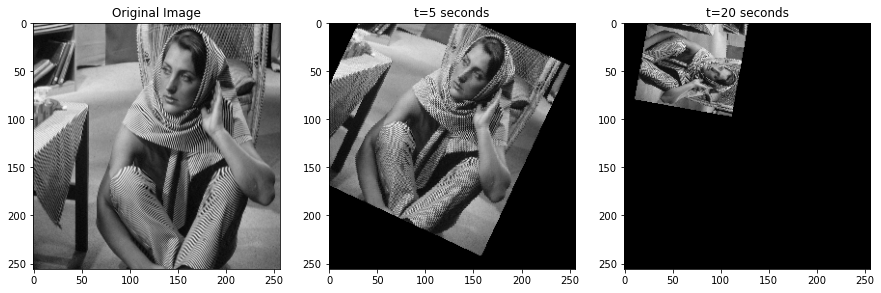

In [8]:
#(a) Special Effect via Compound Linear Geometric Modification
import numpy as np
import matplotlib.pyplot as plt
import math

# Given parameters
s = 3  # Percentage shrink per second
theta = 5  # Degrees rotation per second
m = 2  # Pixels per second translation

# Image dimensions
width, height = 256, 256

# Load the raw image
def load_raw_image(filename, width, height):
    with open(filename, 'rb') as f:
        image = np.fromfile(f, dtype=np.uint8)
    image = image.reshape((height, width))
    return image

# Reverse mapping functions
def reverse_map(x_prime, y_prime, t, center_x, center_y):
    # Scale factor for minification
    scale = 1 - (s / 100) * t
    # Rotation in radians
    rotation = math.radians(theta * t)
    # Translation offset
    translate = m * t

    # Apply minification
    x = x_prime / scale
    y = y_prime / scale
    
    # Apply rotation
    x_rot = (x - center_x) * math.cos(rotation) + (y - center_y) * math.sin(rotation) + center_x
    y_rot = -(x - center_x) * math.sin(rotation) + (y - center_y) * math.cos(rotation) + center_y

    # Apply translation towards south-east direction (down and right)
    x_trans = x_rot + translate
    y_trans = y_rot + translate

    return x_trans, y_trans

# Function to apply the geometric transformation
def apply_geometric_transformation(image, t):
    # Create an empty output image
    output_image = np.zeros_like(image)
    center_x, center_y = width // 2, height // 2

    # Iterate over each pixel in the output image
    for y_prime in range(height):
        for x_prime in range(width):
            # Calculate the reverse mapping
            x, y = reverse_map(x_prime, y_prime, t, center_x, center_y)

            # If the coordinates are within image boundaries
            if 0 <= x < width and 0 <= y < height:
                # Nearest neighbor interpolation
                output_image[y_prime, x_prime] = image[int(y), int(x)]

    return output_image

# Load the raw image file
barbara_raw = load_raw_image('./Project3_Images/barbara.raw', 256, 256)

# Apply the transformation at t=5 and t=20
transformed_image_t5 = apply_geometric_transformation(barbara_raw, t=5)
transformed_image_t20 = apply_geometric_transformation(barbara_raw, t=20)

# Show the original and transformed images
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(barbara_raw, cmap='gray')
plt.title('Original Image')
plt.subplot(1, 3, 2)
plt.imshow(transformed_image_t5, cmap='gray')
plt.title('t=5 seconds')
plt.subplot(1, 3, 3)
plt.imshow(transformed_image_t20, cmap='gray')
plt.title('t=20 seconds')
plt.show()


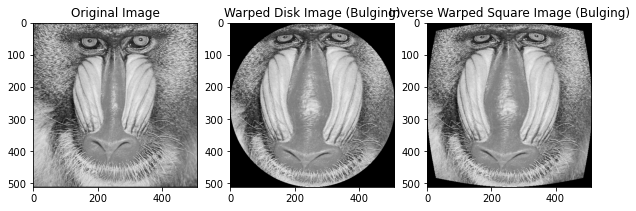

In [6]:
#(b) Spatial warping techniques
import numpy as np
import matplotlib.pyplot as plt

def square_to_disk_mapping(x, y, width, height, bulge_factor):
    # Normalize coordinates to range [-1, 1]
    x_normalized = (2 * x / width) - 1
    y_normalized = (2 * y / height) - 1

    # Calculate polar coordinates
    r = np.sqrt(x_normalized**2 + y_normalized**2)

    # Apply bulge effect using a power function
    r_mapped = r**bulge_factor

    # Discard pixels outside the circular boundary
    if r_mapped > 1:
        return None, None

    theta = np.arctan2(y_normalized, x_normalized)

    # Map polar coordinates to disk
    x_mapped = r_mapped * np.cos(theta)
    y_mapped = r_mapped * np.sin(theta)

    # Denormalize coordinates
    x_mapped = (x_mapped + 1) * 0.5 * width
    y_mapped = (y_mapped + 1) * 0.5 * height

    return x_mapped, y_mapped

def disk_to_square_mapping(x, y, width, height, bulge_factor):
    # Normalize coordinates to range [-1, 1]
    x_normalized = (2 * x / width) - 1
    y_normalized = (2 * y / height) - 1

    # Calculate Cartesian coordinates from polar coordinates
    r = np.sqrt(x_normalized**2 + y_normalized**2)
    theta = np.arctan2(y_normalized, x_normalized)

    # Apply bulge effect using a power function
    r_mapped = r**bulge_factor

    # Map Cartesian coordinates to square
    x_mapped = r_mapped * np.cos(theta)
    y_mapped = r_mapped * np.sin(theta)

    # Denormalize coordinates
    x_mapped = (x_mapped + 1) * 0.5 * width
    y_mapped = (y_mapped + 1) * 0.5 * height

    return x_mapped, y_mapped

# Assuming 'baboon.raw' is the file name
file_path = './Project3_Images/baboon.raw'
width, height = 512, 512  # Adjust these dimensions based on your image size

# Read the raw image file using NumPy
with open(file_path, 'rb') as file:
    raw_data = np.fromfile(file, dtype=np.uint8)
    original_image = raw_data.reshape((height, width))

# Bulge factor controls the strength of the bulging effect
bulge_factor = 1.5

# Forward warping: Square to Disk with Bulging
mapped_image_disk = np.zeros_like(original_image)
for y in range(height):
    for x in range(width):
        x_mapped, y_mapped = square_to_disk_mapping(x, y, width, height, bulge_factor)

        if x_mapped is not None and y_mapped is not None:
            x_mapped_int, y_mapped_int = int(x_mapped), int(y_mapped)
            mapped_image_disk[y, x] = original_image[y_mapped_int, x_mapped_int]

# Inverse warping: Disk to Square with Bulging
mapped_image_square = np.zeros_like(original_image)
for y in range(height):
    for x in range(width):
        x_mapped, y_mapped = disk_to_square_mapping(x, y, width, height, bulge_factor)
        x_mapped_int, y_mapped_int = int(x_mapped), int(y_mapped)

        if 0 <= x_mapped_int < width and 0 <= y_mapped_int < height:
            mapped_image_square[y, x] = original_image[y_mapped_int, x_mapped_int]

# Display the results
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.imshow(original_image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(mapped_image_disk, cmap='gray')
plt.title('Warped Disk Image (Bulging)')

plt.subplot(1, 3, 3)
plt.imshow(mapped_image_square, cmap='gray')
plt.title('Inverse Warped Square Image (Bulging)')

plt.show()


# Problem 2: Texture Analysis and Segmentation <a name="problem-2-texture-analysis-and-segmentation"></a>

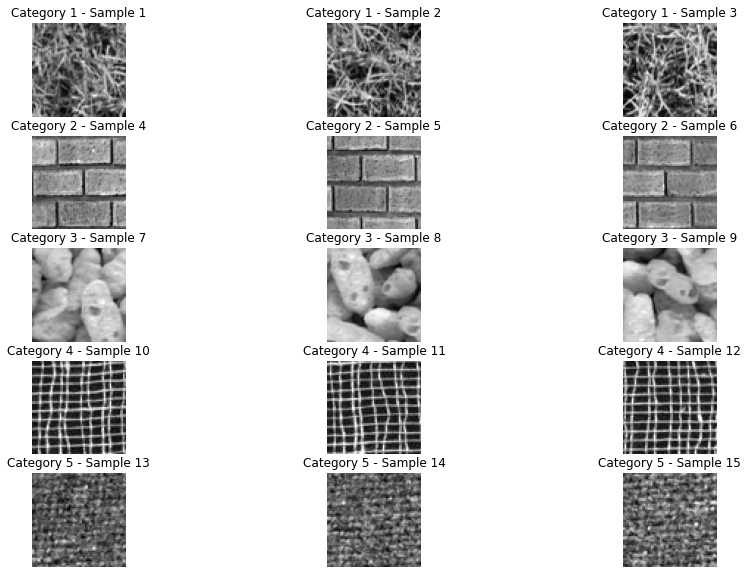

In [4]:
#(a) Texture Classification 
import numpy as np
import matplotlib.pyplot as plt
def read_raw_image(filename, shape):
    with open(filename, 'rb') as f:
        image = np.fromfile(f, dtype=np.uint8, count=np.prod(shape))
        image = image.reshape(shape)
    return image

image_files = []
for i in range(15):
    image_files.append(f'./Project3_Images/sample{i+1}.raw')
image_shape = (64, 64)

# Read and preprocess images
images = [read_raw_image(filename, image_shape) for filename in image_files]
# Visualize the images
# plt.figure(figsize=(15, 5))
# for i in range(15):
#     plt.subplot(3, 5, i + 1)
#     plt.imshow(images[i], cmap='gray')
#     plt.title(f'Sample {i + 1}')
#     plt.axis('off')

# plt.show()

# Assuming you visually grouped the images into 5 categories
categories = {
    'Category 1': [0, 1, 2],
    'Category 2': [3, 4, 5],
    'Category 3': [6, 7, 8],
    'Category 4': [9, 10, 11],
    'Category 5': [12, 13, 14]
}

# Visualize categorized images
plt.figure(figsize=(15, 10))
for category, indices in categories.items():
    for i, index in enumerate(indices):
        plt.subplot(5, 3, i + 1 + (list(categories.keys()).index(category) * 3))
        plt.imshow(images[index], cmap='gray')
        plt.title(f'{category} - Sample {index + 1}')
        plt.axis('off')

plt.show()


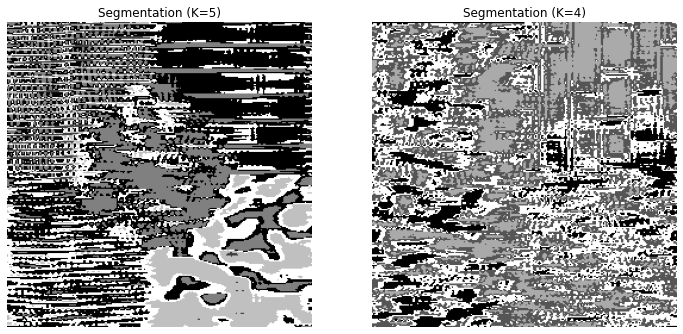

In [5]:
#(b) Texture Segmentation 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
def read_raw_image(filename, shape):
    with open(filename, 'rb') as f:
        image = np.fromfile(f, dtype=np.uint8, count=np.prod(shape))
        image = image.reshape(shape)
    return image

# Assuming you have files comb1.raw and comb2.raw
image_files = ['./Project3_Images/comb1.raw', './Project3_Images/comb2.raw']
image_shapes = [(256, 256), (256, 256)]

# Read and preprocess images
images = [read_raw_image(filename, shape) for filename, shape in zip(image_files, image_shapes)]

def laws_filters(image):
    # Define 1D masks
    L5 = np.array([1, 4, 6, 4, 1])
    E5 = np.array([-1, -2, 0, 2, 1])
    S5 = np.array([-1, 0, 2, 0, -1])
    W5 = np.array([-1, 2, 0, -2, 1])

    # Create 2D masks
    masks = [L5, E5, S5, W5]
    filters = []

    for i in range(4):
        for j in range(4):
            filters.append(np.outer(masks[i], masks[j]))

    # Apply filters to the image
    convolutions = [np.abs(np.convolve(image.flatten(), filter.flatten(), mode='same').reshape(image.shape))
                    for filter in filters]

    return np.stack(convolutions, axis=-1)

# Apply Law's filter to the images
filtered_images = [laws_filters(image) for image in images]

# Flatten the features for k-means clustering
flattened_features = [filtered_image.reshape(-1, filtered_image.shape[-1]) for filtered_image in filtered_images]

def kmeans_segmentation(features, k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(features)
    segmented_image = labels.reshape(images[0].shape)
    return segmented_image

# Set K values for segmentation
k_values = [5, 4]

# Perform segmentation and visualize the results
plt.figure(figsize=(12, 6))

for i, k in enumerate(k_values):
    segmented_image = kmeans_segmentation(flattened_features[i], k)

    plt.subplot(1, 2, i + 1)
    plt.imshow(segmented_image, cmap='gray')
    plt.title(f'Segmentation (K={k})')
    plt.axis('off')

plt.show()


# Problem 3: Optical Character Recognition (OCR) <a name="problem-3-optical-character-recognition-ocr"></a>

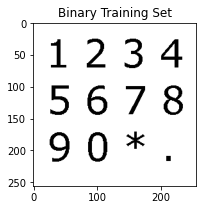

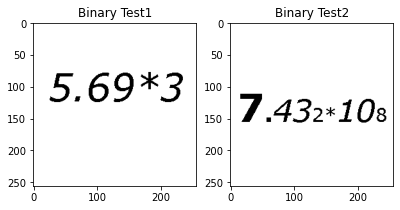

Test1 Result: Numeric
Test2 Result: Numeric


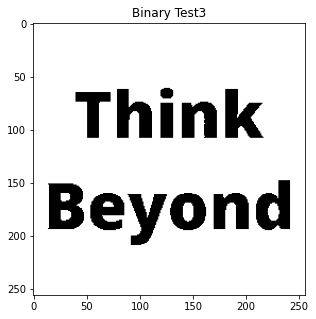

Test3 Result: Numeric


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

# Function to read a raw image
def read_raw_image(filename, shape):
    with open(filename, 'rb') as f:
        image = np.fromfile(f, dtype=np.uint8, count=np.prod(shape))
        image = image.reshape(shape)
    return image

# Function to perform binary thresholding for segmentation
def binary_thresholding(image, threshold):
    if len(image.shape) == 3:
        # For color images, use the red channel for thresholding
        return (image[:, :, 0] > threshold).astype(np.uint8)
    else:
        # For grayscale images, threshold directly
        return (image > threshold).astype(np.uint8)

# Function to extract features from a segmented symbol
def extract_features(symbol):
    # Example features: Area, Perimeter, Aspect Ratio
    area = np.sum(symbol)
    perimeter = np.sum(symbol[1:, :] != symbol[:-1, :]) + np.sum(symbol[:, 1:] != symbol[:, :-1])
    aspect_ratio = symbol.shape[1] / symbol.shape[0]

    return np.array([area, perimeter, aspect_ratio])

# Function for decision tree classification
def decision_tree_classifier(features):
    # Example decision tree: Simple thresholding on aspect ratio
    threshold = 1.5
    if features[2] < threshold:
        return 'Numeric'
    else:
        return 'Arithmetic'

# Read training set and test images
training_set = read_raw_image('./Project3_Images/training.raw', (256, 256, 3))
test1 = read_raw_image('./Project3_Images/test1.raw', (256, 256, 3))
test2 = read_raw_image('./Project3_Images/test2.raw', (256, 256))  # Assume grayscale, adjust if needed

# Binary thresholding for segmentation
threshold = 100  # Adjust as needed
binary_training_set = binary_thresholding(training_set, threshold)
binary_test1 = binary_thresholding(test1, threshold)
binary_test2 = binary_thresholding(test2, threshold)

# Visualize the segmented images
plt.figure(figsize=(10, 3))
plt.subplot(131)
plt.imshow(binary_training_set, cmap='gray')
plt.title('Binary Training Set')
plt.show()


plt.figure(figsize=(10, 3))
plt.subplot(131)

plt.subplot(131)
plt.imshow(binary_test1, cmap='gray')
plt.title('Binary Test1')

plt.subplot(132)
plt.imshow(binary_test2, cmap='gray')
plt.title('Binary Test2')

plt.show()

# Extract features and classify symbols
training_features = [extract_features(binary_training_set)]
training_labels = ['Numeric', 'Numeric', 'Numeric', 'Numeric', 'Numeric', 'Numeric',
                    'Numeric', 'Numeric', 'Numeric', 'Numeric', 'Arithmetic', 'Arithmetic']

test1_features = extract_features(binary_test1)
test2_features = extract_features(binary_test2)

result_test1 = decision_tree_classifier(test1_features)
result_test2 = decision_tree_classifier(test2_features)

print(f'Test1 Result: {result_test1}')
print(f'Test2 Result: {result_test2}')


# Read the new test image
test3 = read_raw_image('./Project3_Images/test3.raw', (256, 256, 3))

# Binary thresholding for segmentation
binary_test3 = binary_thresholding(test3, threshold)

# Visualize the segmented image
plt.figure(figsize=(5, 5))
plt.imshow(binary_test3, cmap='gray')
plt.title('Binary Test3')
plt.show()

# Extract features and classify symbols for test3
test3_features = extract_features(binary_test3)
result_test3 = decision_tree_classifier(test3_features)

print(f'Test3 Result: {result_test3}')